# Connect Demographics

* Breakdown by Age, Gender, Ethnicity and Income
* Breakdown by All Connect / Region / B2B vs. B2C

## Findings:

* **All Connect**:
    * Age: 
        * Majority of connect students are younger than 35 years old. 
        * More than half of this majority are younger than 25 years old.
    * Gender: 
        * Male : Female ~ 1 : 1
    * Ethnicity:
        * According to data we collected, biggest Portion of our students are Asian, next is White.
    * Income:
        * According to data we collected, majority of our students have annual income less than $50K.



* **Region** (US, SA, GB): - no data collected at IN/CN; GB has little data
    * Age:
        * The average age of students in SA is younger than US. Majority of students at SA are between 18-25; majority at US are between 25-35.
    * Gender:
        * US has more Male students than Female; SA has more Female students.
    * Ethnicity:
        * Asian is the biggest portion among US students; at SA there’re more Black / African American students.
    * Income:
        * Both at US and SA students have annual income less than $25K. At US, there’re more students have higher annual income, compared to SA.



* **B2B vs. B2C**:
    * Age:
        * B2B students are between 18 and 35; B2C has ranged from 13-65, majority between 18 and 35.
    * Gender:
        * We have ~ 1:1 gender ratio.
    * Income:
        * B2B students have annual income between $25K - $75K; More students in B2C have annual income less than $50K.

## All Connect by Age, Gender, Ethnicity and Income

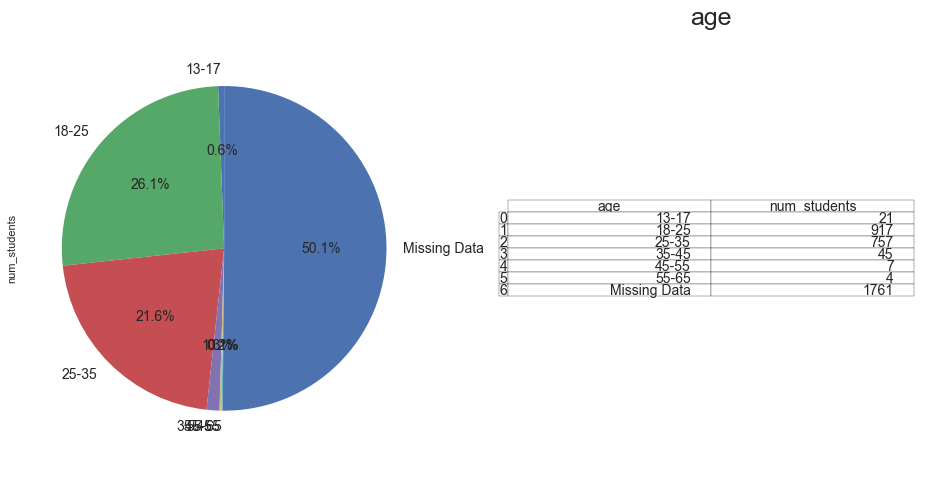

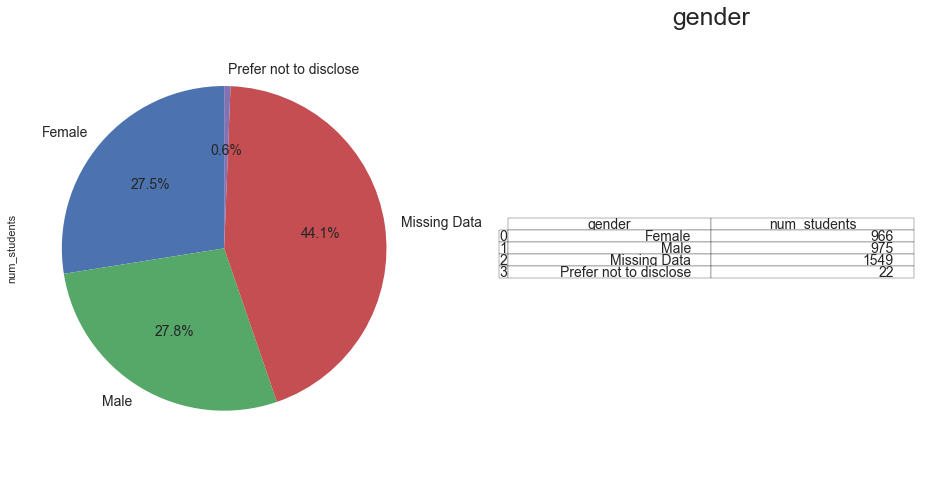

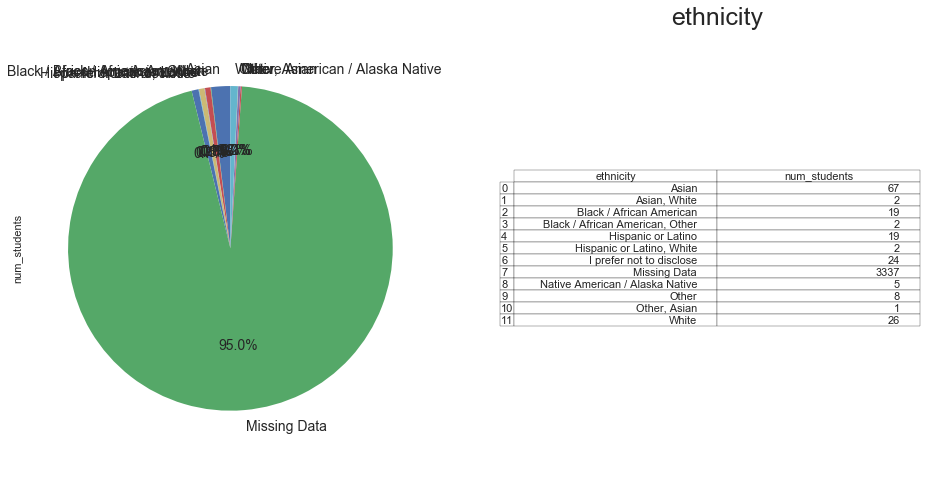

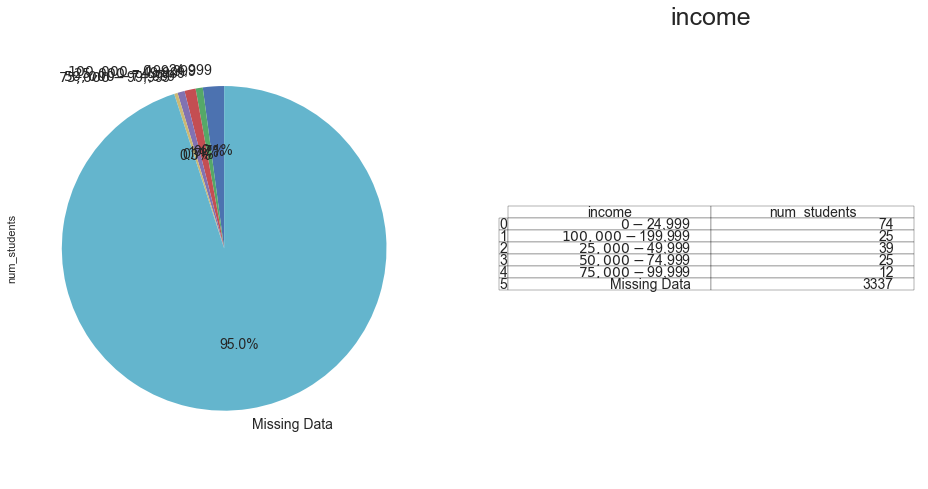

In [7]:
data.plot(by='all')

## All Connect by Age, Gender, Ethnicity and Income; Excluded Missing Data

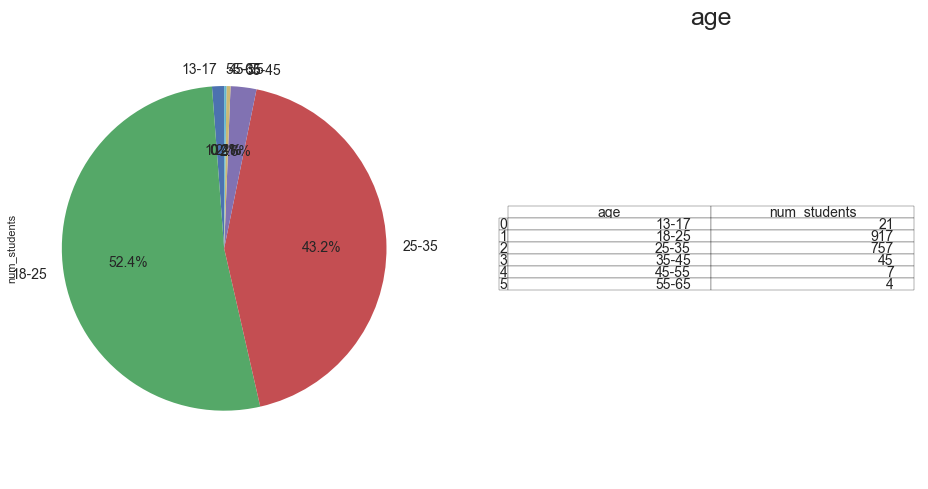

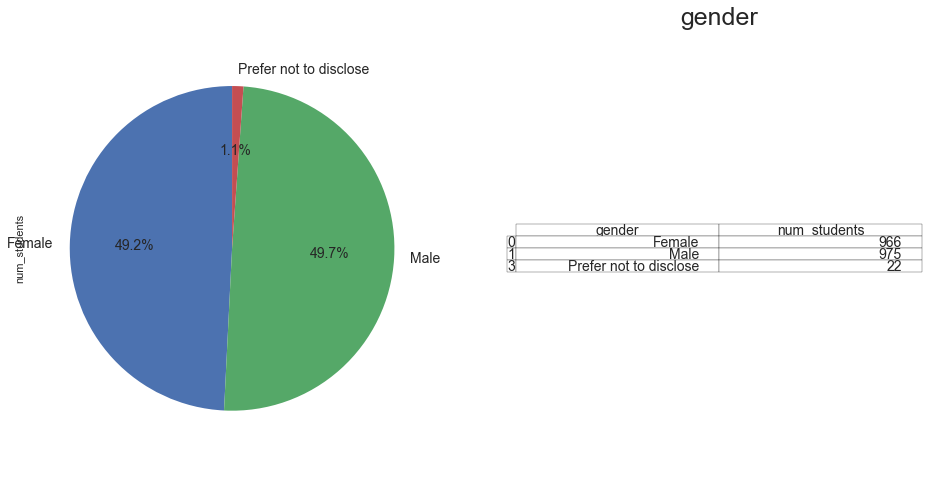

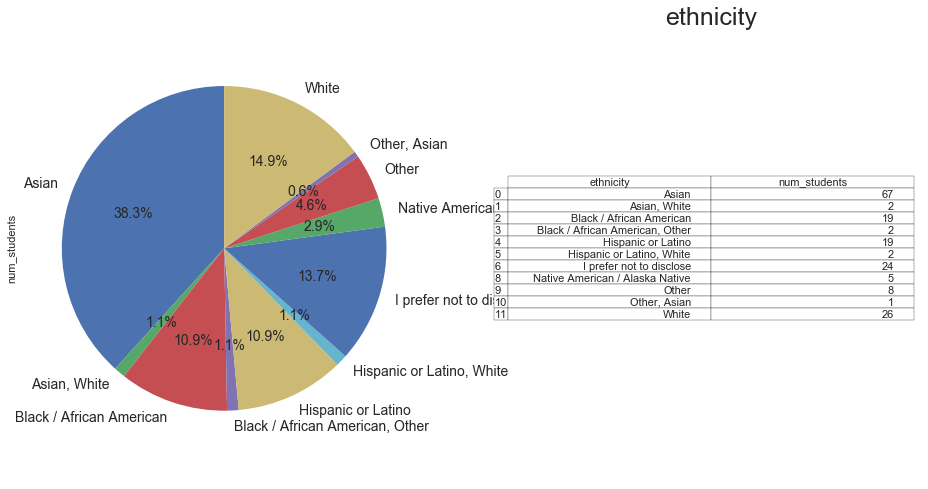

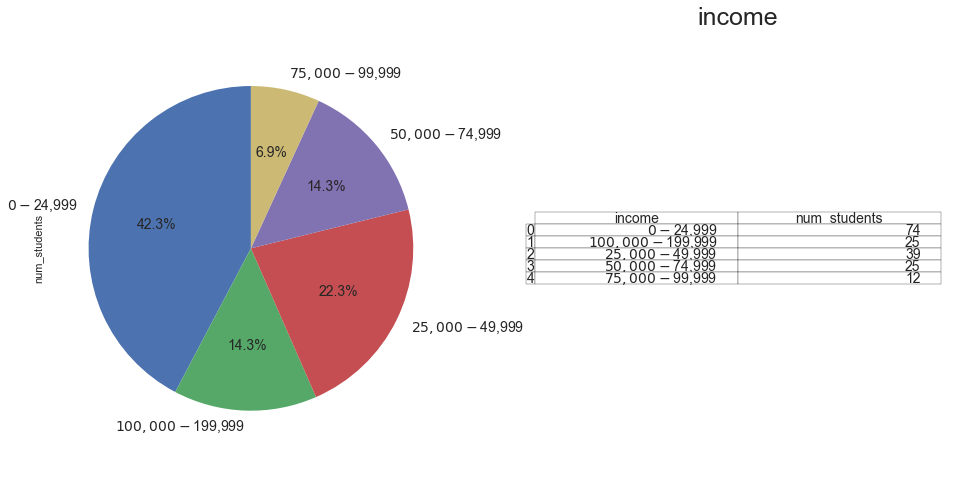

In [8]:
data.plot(by='all',exclude_missing_data=True)

## Region by Age, Gender, Ethnicity and Income; Excluded Missing Data

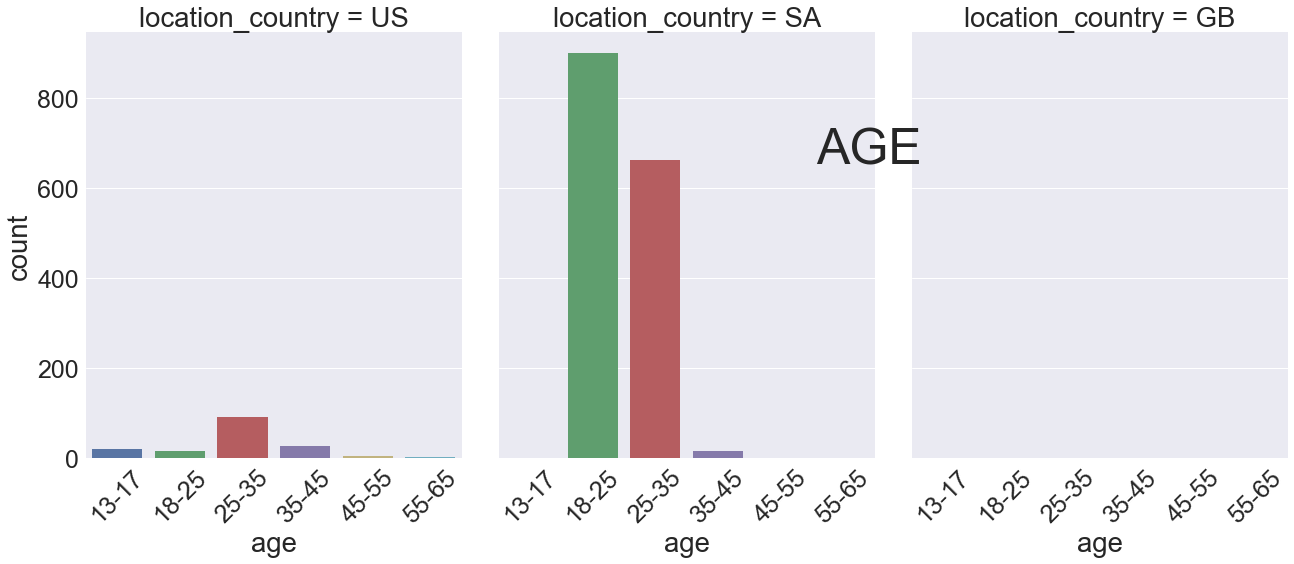

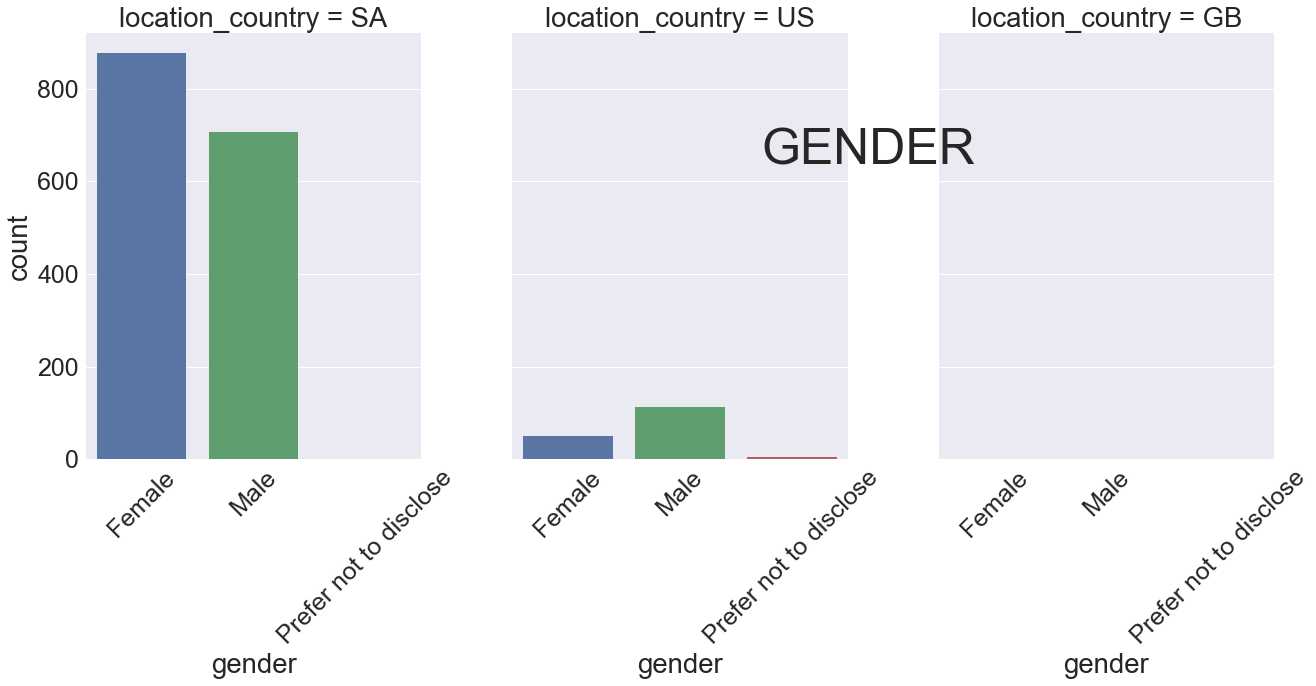

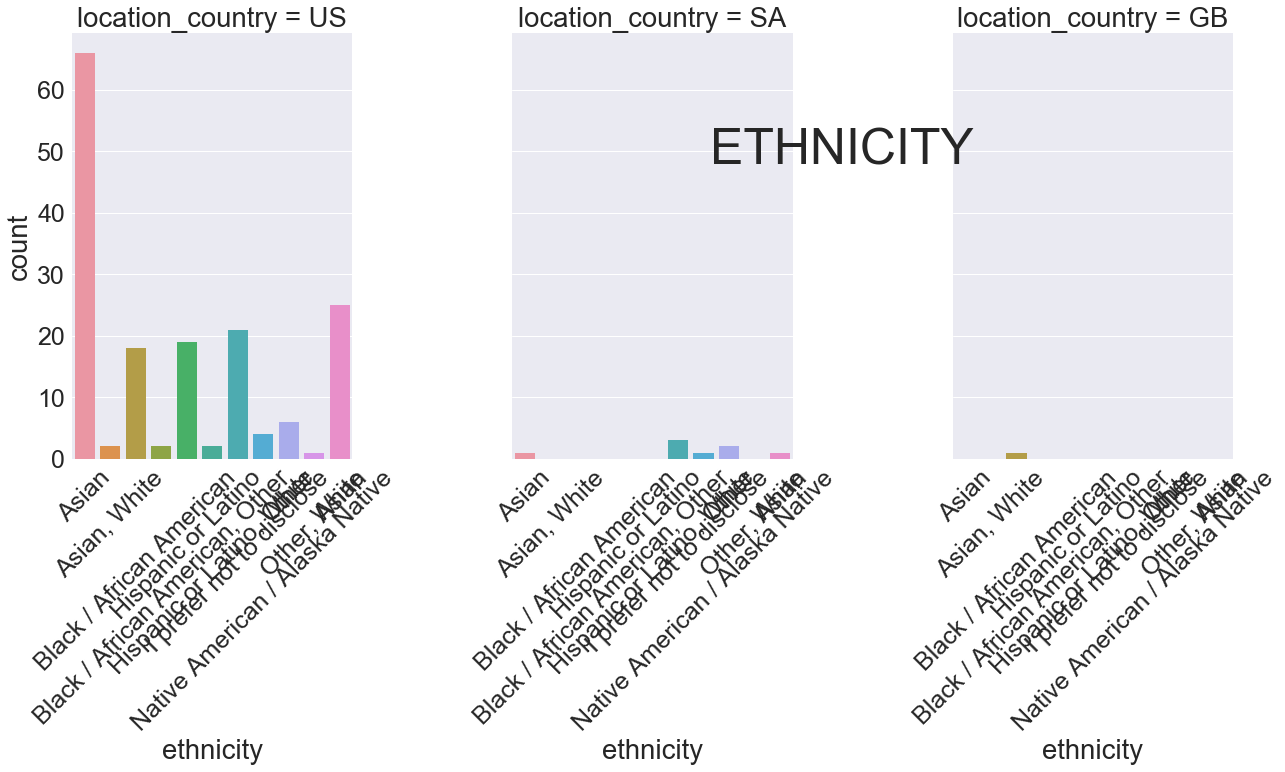

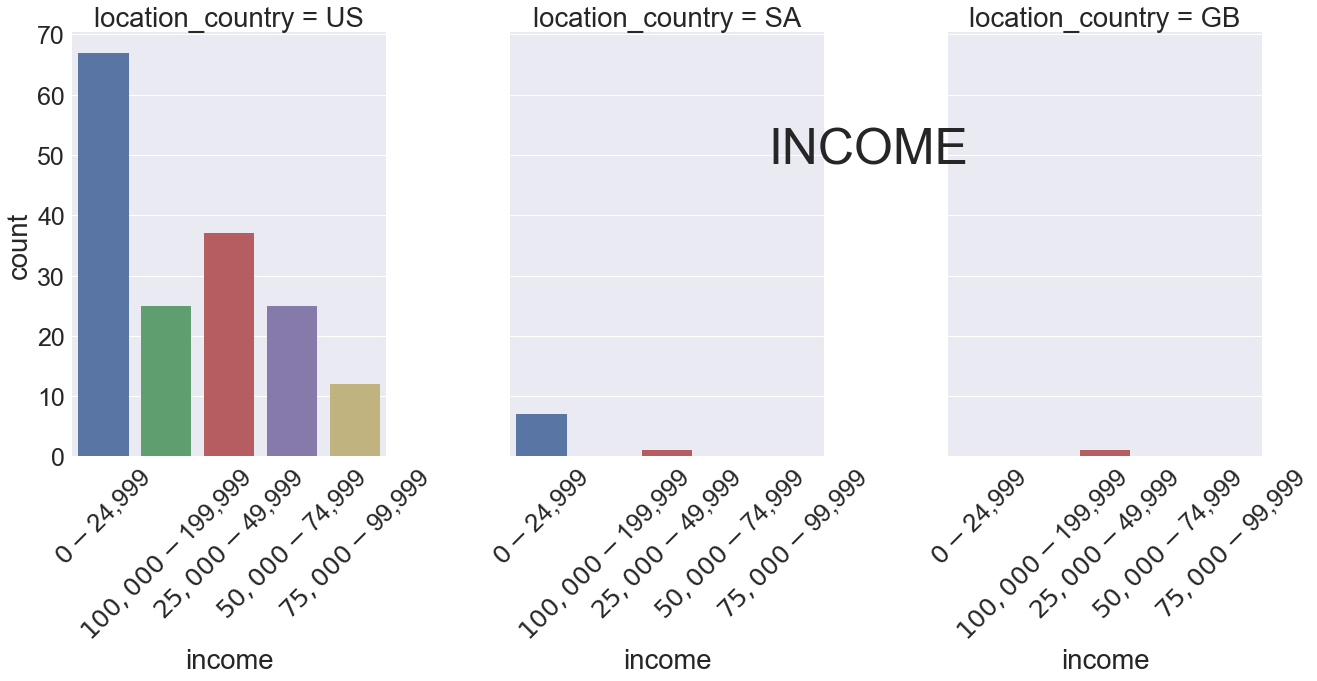

In [9]:
data.plot(by='location_country',exclude_missing_data=True)

## B2B vs. B2C by Age, Gender, Ethnicity and Income; Excluded Missing Data

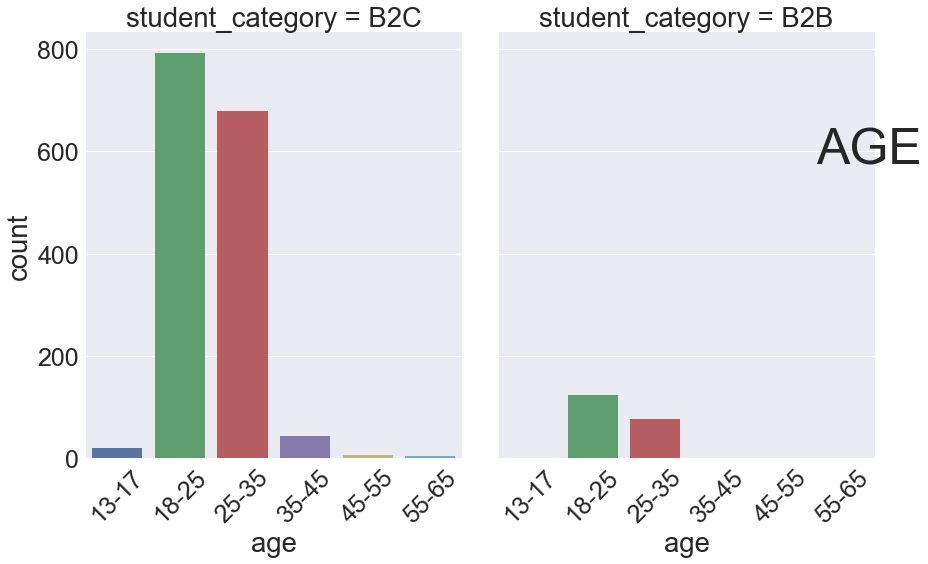

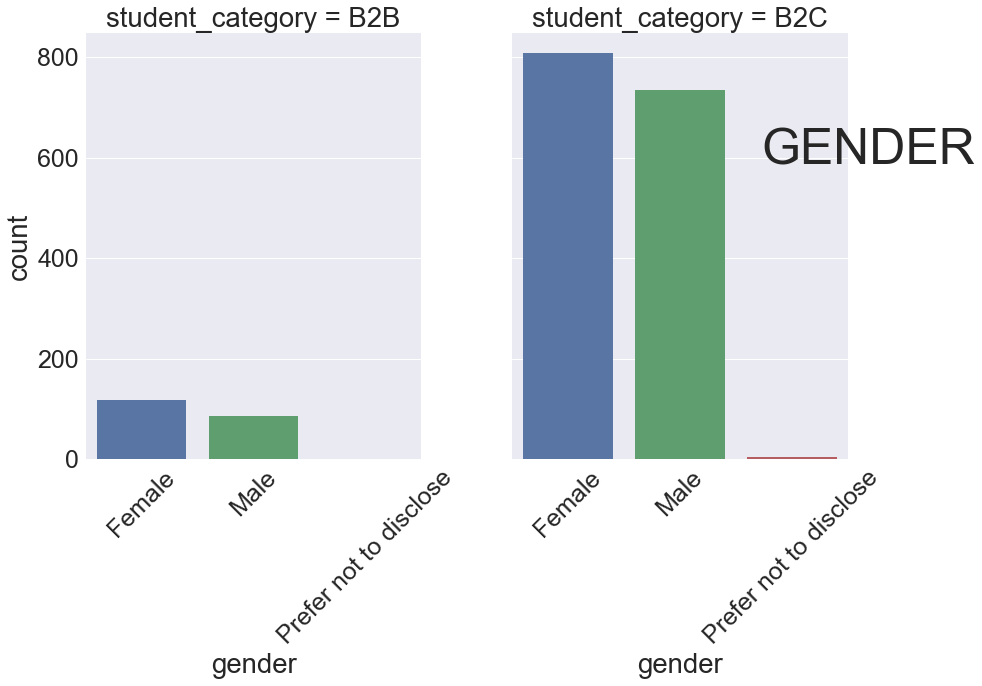

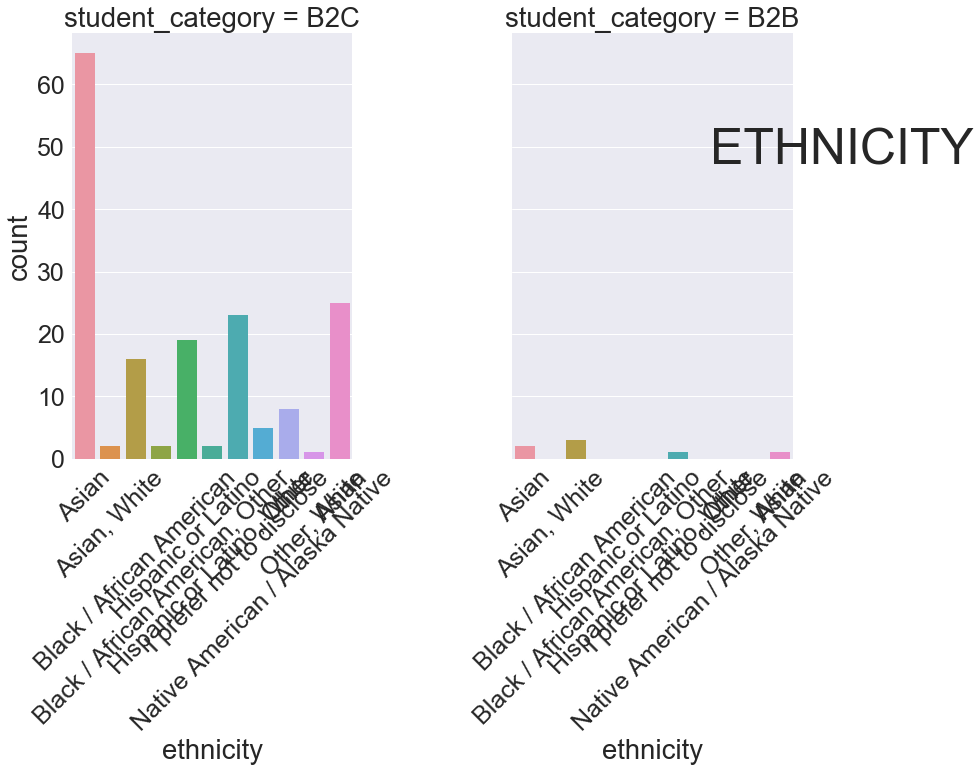

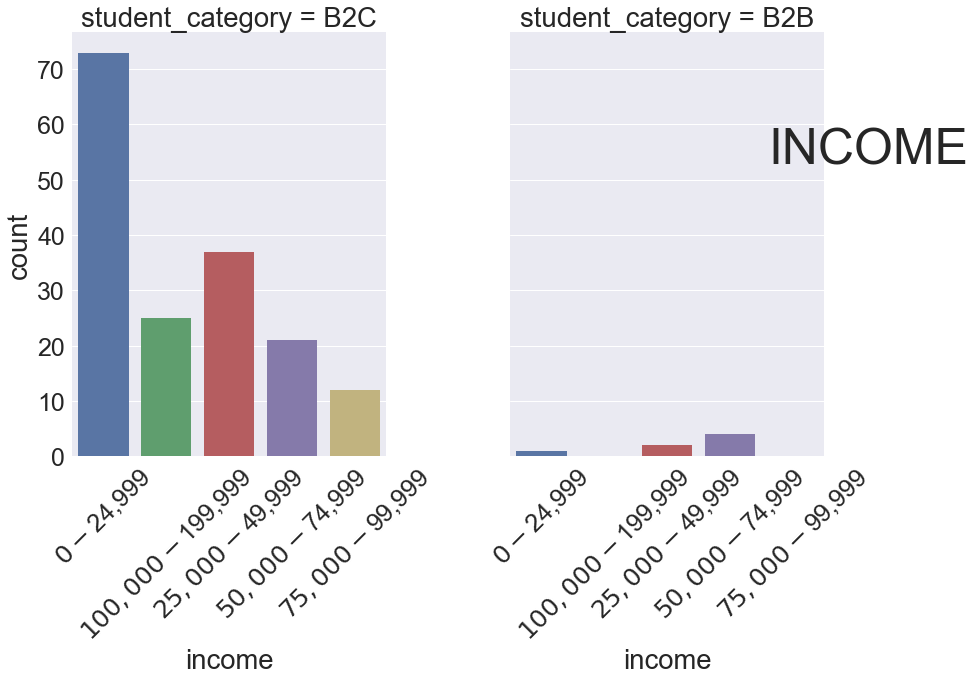

In [10]:
data.plot(by='student_category',exclude_missing_data=True)

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn_laurel = psycopg2.connect("dbname='analytics' user='analytics' host='analytics.cv90snkxh2gd.us-west-2.rds.amazonaws.com' password='!TgP$Ol9Z&6QhKW0tmn9mOW5rYT2J8'")

In [3]:
sql = """
WITH qr_id AS
  (SELECT distinct id
         ,CASE WHEN prompt like '%gender%' THEN 'gender'
               WHEN prompt like '%age%' THEN 'age'
               WHEN prompt like '%ethnicity%' THEN 'ethnicity'
               WHEN prompt like '%income%' THEN 'income'
          END AS category
   FROM admissions.questions
   WHERE category = 'demographics' 
     AND (prompt like '%gender%' OR prompt like '%age%' OR prompt like '%ethnicity%' OR prompt like '%income%')
  ),

students AS
  (SELECT distinct a.session_id,a.session_product_type,a.degree,a.account_key,a.location_country,a.location_state,a.location_name,b.id,b.category
   FROM uconnect_enrollments a,qr_id b
  ),

students2 AS
  (SELECT distinct a.*,b.affiliate_key,b.variant,case when b.variant is not null then 'B2B' else 'B2C' end AS student_category
   FROM students a
   LEFT JOIN affiliates.affiliate_deployments b on a.account_key = b.account_key and left(a.degree,5) = left(b.nd_key,5)
   ---INNER JOIN accounts c ON a.account_key = c.account_key AND c.email NOT LIKE '%@udacity%'
  )

SELECT a.session_id,a.degree,a.location_country,a.location_state,a.location_name
      ,a.account_key,a.student_category,a.category,a.id,c.response,c.response_updated_at
      ,row_number() OVER (PARTITION BY a.account_key,a.session_id,a.category ORDER BY coalesce(c.response_updated_at::date,'1900-01-01') DESC) AS row_num
FROM students2 a
---LEFT JOIN applications b on a.account_key = b.applicant_id and left(a.degree,5) = left(b.nd_key,5)
---LEFT JOIN admissions.question_responses c ON a.account_key = c.applicant_id and c.question_id = a.id
LEFT JOIN test_yidong.connect_question_responses c ON a.account_key = c.applicant_id and c.question_id = a.id
  AND (c.response IS NOT NULL OR c.response != '')
;
"""

In [4]:
df = pd.read_sql(sql,conn_laurel)

In [5]:
class demographics:
    
    def __init__(self,data):
        
        self.data = data
        self.process_data = self.process_data()
    
    def process_data(self):
        
        df = self.data
        
        df = df[df['row_num']==1]
        df['response'] = ['Missing Data' if not x else x for x in df['response']]
        demographics = pd.pivot_table(df, values='response', index=['account_key'],columns=['category'],aggfunc=np.max).reset_index()
        data = df[['session_id','degree','location_country','account_key','student_category']]
        data = pd.merge(data,demographics,on='account_key',how='left').drop_duplicates()
        
        def age_process(df):
            for val in pd.Series(df.age):
                if '/' in val:
                    age = datetime.date.today().year - int(re.findall(r"[0-9]{4}",'12/21/1987')[0]) + 1
                    return str(age)
                elif re.match(r"[0-9]{4}",val):
                    age = datetime.date.today().year - int(re.findall(r"[0-9]{4}",'12/21/1987')[0]) + 1
                    return str(age)
                elif val == 'twenty three':
                    return '23'
                elif ('year' in val) | ('old' in val):
                    return val[:2]
                else:
                    return val.strip()

        def age_process2(df):
            for val in pd.Series(df.age):
                if val == '13-17':
                    return val
                elif val == '18-22':
                    return '18-25'
                elif val == '18-24':
                    return '18-25'
                elif val == '23-25':
                    return '18-25'
                elif val == '25-34':
                    return '25-35'
                elif val == '26-30':
                    return '25-35'
                elif val == '31-35':
                    return '25-35'
                elif val == '35-44':
                    return '35-45'
                elif val == '36-40':
                    return '35-45'
                elif val == '45-54':
                    return '45-55'
                elif val == '55-64':
                    return '55-65'
                elif val == 'Missing Data':
                    return val
                else:
                    if int(val) <= 17:
                        return '13-17'
                    elif int(val) <= 25:
                        return '18-25'
                    elif int(val) <= 35:
                        return '25-35'
                    elif int(val) <= 45:
                        return '35-45'
                    elif int(val) <= 55:
                        return '45-55'
                    elif int(val) <= 65:
                        return '55-65'
        
        def gender_process(df):
            for val in pd.Series(df.gender):
                if 'no' in val.lower():
                    return 'Prefer not to disclose'
                else:
                    return val.strip()
        
        data['age'] = data.apply(age_process,axis=1)
        data['age'] = data.apply(age_process2,axis=1)
        data['gender'] = data.apply(gender_process,axis=1)
        
        return data
    
    def plot(self,by='all',exclude_missing_data=False):
        
        data = self.process_data
        
        if by == 'all':
            
            for i in ['age','gender','ethnicity','income']:

                d_i = data.groupby([i])['account_key'].count().rename('num_students').reset_index()
                
                if exclude_missing_data:
                    d_i = d_i[d_i[i]!='Missing Data']
                else:
                    d_i = d_i

                plt.figure(figsize=(16,8))
                # plot chart
                ax1 = plt.subplot(121, aspect='equal')
                d_i.plot(kind='pie', y = 'num_students', ax=ax1, autopct='%1.1f%%', 
                 startangle=90, shadow=False, labels=d_i[i], legend=False, fontsize=14)

                # plot table
                ax2 = plt.subplot(122)
                plt.axis('off')
                plt.title(i,fontsize=25)
                tbl = pd.plotting.table(ax2, d_i, loc='center')
                tbl.auto_set_font_size(True)
                tbl.set_fontsize(14)
                #plt.legend(fontsize=5)
                plt.show()
                
        else:
            
            for i in ['age','gender','ethnicity','income']:
                
                if exclude_missing_data:
                    data = data[data[i]!='Missing Data']
                else:
                    data = data
                
                sns.set(font_scale=2.5)
                g = sns.factorplot(i, col=by, col_wrap=4, data=data.sort_values(by=i), 
                                   kind="count", size=6, aspect=1, legend=True)
                g.set_xticklabels(rotation=45)
                plt.subplots_adjust(top=1.2)
                g.fig.suptitle(i.upper(),fontsize=50)
                g.fig.subplots_adjust(hspace=.8)
                
                '''
                for j in list(data[by].unique()):

                    d_j = data[data[by]==j]
                    d_j = d_j.groupby([i])['account_key'].count().rename('num_students').reset_index()

                    plt.figure(figsize=(16,8))
                    # plot chart
                    ax1 = plt.subplot(121, aspect='equal')
                    d_j.plot(kind='pie', y = 'num_students', ax=ax1, autopct='%1.1f%%', 
                     startangle=90, shadow=False, labels=d_j[i], legend = True, fontsize=14)

                    # plot table
                    ax2 = plt.subplot(122)
                    plt.axis('off')
                    title = i+": "+j
                    plt.title(title,fontsize=25)
                    tbl = pd.plotting.table(ax2, d_j, loc='center')
                    tbl.auto_set_font_size(False)
                    tbl.set_fontsize(14)
                    plt.show()
                    '''


In [6]:
data = demographics(df)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


## Archive

In [ ]:
d = df[df['row_num']==1]
d['response'] = ['Missing Data' if not x else x for x in d['response']]
demographics = pd.pivot_table(d, values='response', index=['account_key'],columns=['category'],aggfunc=np.max).reset_index()
data = d[['session_id','degree','location_country','account_key','student_category']]
data = pd.merge(data,demographics,on='account_key',how='left').drop_duplicates()
data

### Age

In [ ]:
def age_process(df):
    for val in pd.Series(df.age):
        if '/' in val:
            age = datetime.date.today().year - int(re.findall(r"[0-9]{4}",'12/21/1987')[0]) + 1
            return str(age)
        elif re.match(r"[0-9]{4}",val):
            age = datetime.date.today().year - int(re.findall(r"[0-9]{4}",'12/21/1987')[0]) + 1
            return str(age)
        elif val == 'twenty three':
            return '23'
        elif ('year' in val) | ('old' in val):
            return val[:2]
        else:
            return val.strip()

def age_process2(df):
    for val in pd.Series(df.age):
        if val == '13-17':
            return val
        elif val == '18-22':
            return '18-25'
        elif val == '18-24':
            return '18-25'
        elif val == '23-25':
            return '18-25'
        elif val == '25-34':
            return '25-35'
        elif val == '26-30':
            return '25-35'
        elif val == '31-35':
            return '25-35'
        elif val == '35-44':
            return '35-45'
        elif val == '36-40':
            return '35-45'
        elif val == '45-54':
            return '45-55'
        elif val == '55-64':
            return '55-65'
        elif val == 'Missing Data':
            return val
        else:
            if int(val) <= 17:
                return '13-17'
            elif int(val) <= 25:
                return '18-25'
            elif int(val) <= 35:
                return '25-35'
            elif int(val) <= 45:
                return '35-45'
            elif int(val) <= 55:
                return '45-55'
            elif int(val) <= 65:
                return '55-65'

In [ ]:
data['age'] = data.apply(age_process,axis=1)
data['age'] = data.apply(age_process2,axis=1)

In [ ]:
age = data.groupby(['age'])['account_key'].count().rename('num_students').reset_index()
age

In [ ]:
plt.figure(figsize=(16,8))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
age.plot(kind='pie', y = 'num_students', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=age['age'], legend = False, fontsize=14)

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
plt.title('Age',fontsize=25)
tbl = pd.tools.plotting.table(ax2, age, loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
plt.show()

### Gender

In [ ]:
def gender_process(df):
    for val in pd.Series(df.gender):
        if 'no' in val.lower():
            return 'Prefer not to disclose'
        else:
            return val.strip()

In [ ]:
data['gender'] = data.apply(gender_process,axis=1)

In [ ]:
gender = data.groupby(['gender'])['account_key'].count().rename('num_students').reset_index()
gender

In [ ]:
plt.figure(figsize=(16,8))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
gender.plot(kind='pie', y = 'num_students', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=age['gender'], legend = False, fontsize=14)

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
plt.title('Gender',fontsize=25)
tbl = pd.tools.plotting.table(ax2, gender, loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
plt.show()

### Ethnicity

In [ ]:
ethnicity = data.groupby(['ethnicity'])['account_key'].count().rename('num_students').reset_index()
ethnicity

In [ ]:
plt.figure(figsize=(16,8))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
ethnicity.plot(kind='pie', y = 'num_students', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=ethnicity['ethnicity'], legend = False, fontsize=14)

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
plt.title('Ethnicity',fontsize=25)
tbl = pd.tools.plotting.table(ax2, ethnicity, loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
plt.show()

### Income

In [ ]:
income = data.groupby(['income'])['account_key'].count().rename('num_students').reset_index()
income

In [ ]:
plt.figure(figsize=(16,8))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
income.plot(kind='pie', y = 'num_students', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=income['income'], legend = True, fontsize=14)

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
plt.title('Income',fontsize=25)
tbl = pd.plotting.table(ax2, income, loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
plt.show()